count: 1


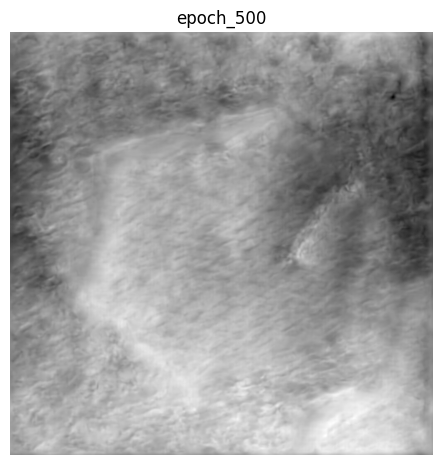

In [10]:
import os
import glob
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.nn.functional as F

from normal_m import UNet  # 确保正确导入您的 UNet 模型
from utils import poisson_reconstruct  # 确保正确导入 poisson_reconstruct 函数

class TestDepthDataset(Dataset):
    def __init__(self, image_paths, depth_paths):
        self.image_paths = image_paths
        self.depth_paths = depth_paths

    def __len__(self):
        return len(self.depth_paths)

    def __getitem__(self, idx):
        images = []
        for img_path in self.image_paths[idx]:
            img = Image.open(img_path).convert('L')
            img = img.resize((1024, 1024))
            img = transforms.ToTensor()(img)
            images.append(img)
        input_tensor = torch.cat(images, dim=0)  # [4, H, W]

        # 加载深度图
        depth = np.load(self.depth_paths[idx]).astype(np.float32)
        depth = torch.from_numpy(depth)  # [H, W]

        return input_tensor, depth  # 返回输入和标签深度图

def get_test_data_loader(dataset_dir, batch_size=1, num_workers=0):
    image_dir = os.path.join(dataset_dir, 'test_image')
    depth_dir = os.path.join(dataset_dir, 'test_depth')
    image_files = glob.glob(os.path.join(image_dir, '*.png'))
    group_images = defaultdict(list)

    for img_file in image_files:
        filename = os.path.basename(img_file)
        group_num, angle = filename.split('.')[0].split('-')
        group_images[group_num].append(img_file)

    valid_image_paths = []
    valid_depth_paths = []
    count = 0
    for group_num, img_list in group_images.items():
        if len(img_list) == 4:
            depth_file = os.path.join(depth_dir, f'{group_num}.npy')
            if os.path.exists(depth_file):
                img_list.sort(key=lambda x: int(
                    os.path.basename(x).split('-')[1].split('.')[0]))
                valid_image_paths.append(img_list)
                valid_depth_paths.append(depth_file)
                count += 1
            else:
                print(f"Error: {depth_file}")
        else:
            print(f"{group_num}  Error: {len(img_list)}")
    print(f"count: {count}")

    dataset = TestDepthDataset(valid_image_paths, valid_depth_paths)
    dataloader = DataLoader(dataset, batch_size=batch_size,
                            shuffle=False, num_workers=num_workers)
    return dataloader

if __name__ == "__main__":
    dataset_dir = 'testset'  
    test_loader = get_test_data_loader(dataset_dir, batch_size=1)

    model = UNet()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model_path = 'model'
    depth_list = []
    for model_m in os.listdir(model_path):
        if model_m != 'unet_epoch_75500.pth':
            continue
    # model_list = [500,4500,6500,8000,8500,9000,9500]
    # pred_depth = [np.zeros((1024, 1024)) for _ in range(len(model_list))]
    # for model_num in model_list:
        if model_m.endswith('.pth'):    
            # model.load_state_dict(torch.load(f'model/unet_epoch_{model_num}.pth', map_location=device))
            model.load_state_dict(torch.load(f'model/{model_m}', map_location=device))
            model.eval()

            with torch.no_grad():
                for i, (inputs, depth_gt) in enumerate(test_loader):
                    inputs = inputs.to(device)  # [batch_size, 4, H, W]
                    depth_gt = depth_gt.to(device)  # [batch_size, H, W]

                    # 运行模型，得到预测的法线图
                    outputs = model(inputs)  # [batch_size, 3, H, W]
                    N_pred = outputs  # [batch_size, 3, H, W]

                    # 从预测的法线图重建深度图
                    gx_pred = -N_pred[:, 0, :, :]  # [batch_size, H, W]
                    gy_pred = -N_pred[:, 1, :, :]  # [batch_size, H, W]

                    depth_pred = poisson_reconstruct(gx_pred, gy_pred)  # [batch_size, H, W]

                    # 可视化标签的深度图和预测的深度图
                    depth_gt_np = depth_gt[0].cpu().numpy()  # [H, W]
                    depth_pred_np = depth_pred[0].cpu().numpy()  # [H, W]
                    # pred_depth[model_list.index(model_num)] += depth_pred_np
                    depth_list.append(depth_pred_np)
                    
                    np.save('pred_depth_75500.npy', depth_pred_np)
    x = len(depth_list)//2
    left = len(depth_list)%2
    y = 2
    plt.figure(figsize=(12, 6*(x+left) if left != 0 else 6*x) )
    for i in range(len(depth_list)):
        # print(len(depth_list),i,x,y)
        plt.subplot(x+left if left != 0 else x,y,i+1)
        plt.imshow(depth_list[i], cmap='gray')
        plt.title(f'epoch_{(i+1)*500}')
        plt.axis('off')
                # 归一化深度图以便于可视化
                # depth_gt_norm = (depth_gt_np - depth_gt_np.min()) / (depth_gt_np.max() - depth_gt_np.min())
                # depth_pred_norm = (depth_pred_np - depth_pred_np.min()) / (depth_pred_np.max() - depth_pred_np.min())

                # plt.figure(figsize=(12, 6))
                # plt.subplot(1, 2, 1)
                # plt.imshow(depth_gt_norm, cmap='gray')
                # plt.title('标签深度图')
                # plt.axis('off')

                # plt.subplot(1, 2, 2)
                # plt.imshow(depth_pred_norm, cmap='gray')
                # plt.title('预测深度图')
                # plt.axis('off')

                # plt.show()

                # 如果只想查看第一个样本，可以取消注释以下代码
                # break


In [2]:
import torch
torch.cuda.is_available()

True

In [9]:
import numpy as np
import matplotlib.pyplot as plt
data = np.load('pred_depth_75500.npy')
plt.imshow(data, cmap='gray')
height, width = data.shape
with open('75500.xyz', 'w') as file:
    for y in range(height):
        for x in range(width):
            z = data[y, x]
            file.write(f"{x} {y} {z}\n")
